In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.signal import butter, filtfilt, sosfiltfilt
from datetime import datetime
import scipy.signal as sig

### Filter data

In [2]:
def high_pass(data):
    """
    Applies a high pass filter to the voltage data in the dataframe.

    Parameters:
    data: A Pandas dataframe containing the voltage data.

    Returns:
    A Pandas dataframe containing the flitered voltages of the two channels
    """
    # Define the cutoff frequency (in Hz) for the high pass filter
    cutoff_freq = 1

    # Define the filter order
    filter_order = 8

    # Define the sampling rate (in Hz) for the voltage data
    sampling_rate = 250

    # Define the voltage variable
    voltage_chan_1 = data.iloc[:, 0].values
    voltage_chan_2 = data.iloc[:, 1].values

    # Define the filter coefficients
    nyquist_freq = sampling_rate / 2
    normalized_cutoff_freq = cutoff_freq / nyquist_freq
    a = butter(filter_order, normalized_cutoff_freq, btype='highpass', output='sos')

    # Apply the filter to the voltage data
    voltage_chan_1 = sosfiltfilt(a, voltage_chan_1)
    voltage_chan_2 = sosfiltfilt(a, voltage_chan_2)

    return pd.DataFrame({'FP1 (channel 1)': voltage_chan_1, 'FP2 (channel 2)': voltage_chan_2})


def low_pass(data):
    """
    Applies a low pass filter to the voltage data in a Pandas dataframe.

    Parameters:
    data: A Pandas dataframe containing the voltage data.

    Returns:
    A Pandas dataframe containing the flitered voltages of the two channels
    """
    # Define the cutoff frequency (in Hz) for the low pass filter
    cutoff_freq = 5

    # Define the filter order
    filter_order = 8

    # Define the sampling rate (in Hz) for the voltage data
    sampling_rate = 250

    # Define the voltage variable
    voltage_chan_1 = data.iloc[:, 0].values
    voltage_chan_2 = data.iloc[:, 1].values

    # Define the filter coefficients
    nyquist_freq = sampling_rate / 2
    normalized_cutoff_freq = cutoff_freq / nyquist_freq
    a = butter(filter_order, normalized_cutoff_freq, btype='lowpass', output='sos')

    # Apply the filter to the voltage data
    voltage_chan_1 = sosfiltfilt(a, voltage_chan_1)
    voltage_chan_2 = sosfiltfilt(a, voltage_chan_2)

    return pd.DataFrame({'FP1 (channel 1)': voltage_chan_1, 'FP2 (channel 2)': voltage_chan_2})


def average_min_max(data):
    """
    Calculate the average minimum and maximum filtered and normalized voltage 
    value for channel 1 and 2 based on a manually set threashold.

    Parameters:
    data: A Pandas dataframe containing the filtered voltage data.

    Returns:
    min_1, min_2: averaged minimum value of channel 1 and 2.
    max_1, max_2: averaged maximum value of channel 1 and 2.
    """  
    min_1, max_1, num_min_1, num_max_1= 0, 0, 0, 0
    min_2, max_2, num_min_2, num_max_2= 0, 0, 0, 0
    voltage_chan_1 = data.iloc[:, 0].values
    voltage_chan_2 = data.iloc[:, 1].values

    for i in range(len(voltage_chan_1)):
        # Calculation for channel 1 based on manually set threashold
        if (voltage_chan_1[i] <= -100):
            min_1 += voltage_chan_1[i]
            num_min_1 += 1
        elif (voltage_chan_1[i] >= 70):
            max_1 += voltage_chan_1[i]
            num_max_1 += 1

        # Calculation for channel 2 based on manually set threashold
        if (voltage_chan_2[i] <= -100):
            min_2 += voltage_chan_2[i]
            num_min_2 += 1
        elif (voltage_chan_2[i] >= 70):
            max_2 += voltage_chan_2[i]
            num_max_2 += 1

    return (min_1 / num_min_1), (max_1 / num_max_1), (min_2 / num_min_2), (max_2 / num_max_2)


def preprocess(df):
    df = df.loc[6:,:]
    data = df.iloc[:,1:3]
    time = df.iloc[:, -2]

    # Visualize the raw eye blink data
    plt.plot(time, data.iloc[:, 0], label='chan_1')
    plt.plot(time, data.iloc[:, 1], label='chan_2')
    plt.title("Raw Data")
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage')
    plt.legend()
    plt.show()

    
    filtered = high_pass(data)
    print("After applying high pass filter")
    # Visualize the data after applying the high pass filter
    plt.plot(time, filtered.iloc[:, 0], label='chan_1')
    plt.plot(time, filtered.iloc[:, 1], label='chan_2')
    plt.title("High-Passed Data")
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage')
    plt.legend()
    plt.show()

    filtered = low_pass(filtered)
    print("After applying low pass filter")
    # Visualize the data after applying the low pass filter
    plt.plot(time, filtered.iloc[:, 0], label='chan_1')
    plt.plot(time, filtered.iloc[:, 1], label='chan_2')
    plt.title("Low-Passed Data")
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage')
    plt.legend()
    plt.show()

    avg_min_1, avg_max_1, avg_min_2, avg_max_2 = average_min_max(filtered)
    print("Average minimum and maximum voltage values found for FP1 (channel 1): ", avg_min_1, avg_max_1)
    print("Average minimum and maximum voltage values found for FP2 (channel 2): ", avg_min_2, avg_max_2)

    return filtered

epoch_seconds = 5.2
epoch = int(epoch_seconds / 0.004)

def divide_dataset(data, time):
    num_epoch = math.ceil(len(time) / epoch)
    data_subsets = []
    time_subsets = []
    start = 0
    for i in range(num_epoch):
        if start + epoch >= len(time):
            data_subsets.append(data.iloc[start:,:])
            time_subsets.append(time[start:])       
        else:
            data_subsets.append(data.iloc[start:start + epoch,:])
            time_subsets.append(time[start:start + epoch])
            start = start + epoch
    return data_subsets, time_subsets

def svt(data, avg_min_1, avg_max_1, avg_min_2, avg_max_2):
    min_1, min_2 = np.min(data).values
    max_1, max_2 = np.max(data).values
    
    min_flag_1 = min_1 <= avg_min_1
    max_flag_1 = max_1 >= avg_max_1
    min_flag_2 = min_2 <= avg_min_1
    max_flag_2 = max_2 >= avg_max_1
    
    return min_flag_1 or max_flag_1 or min_flag_2 or max_flag_2

In [3]:
df = pd.read_csv('Subject_4/CSV/BrainFlow-RAW_2023-03-07_11-46-58_44.csv', delimiter='\t')

In [4]:
#df

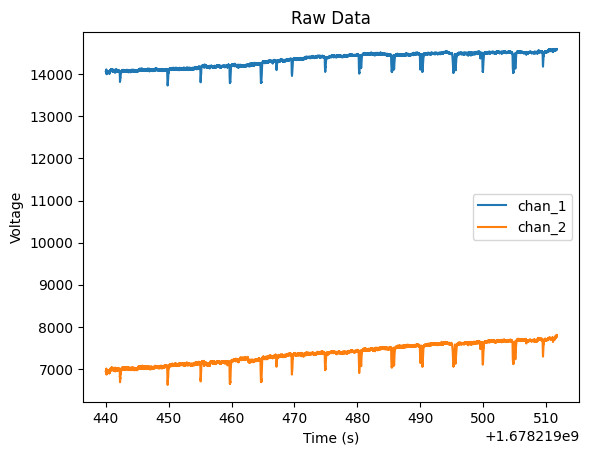

After applying high pass filter


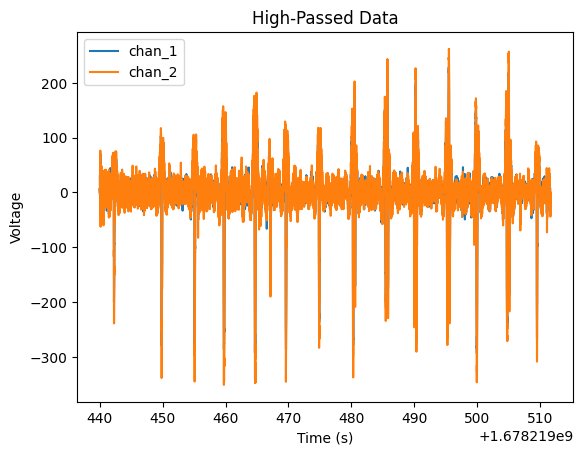

After applying low pass filter


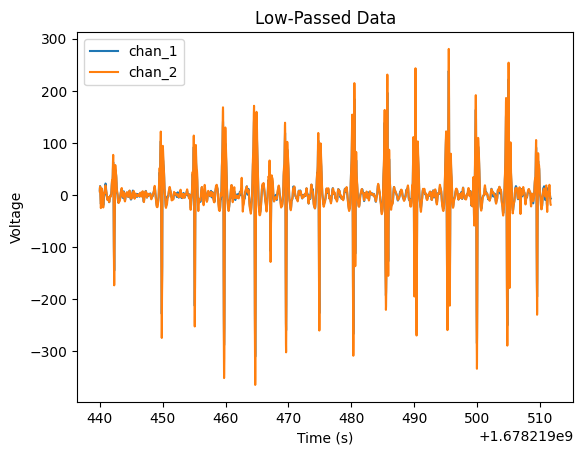

Average minimum and maximum voltage values found for FP1 (channel 1):  -179.95123383893812 110.28452317761975
Average minimum and maximum voltage values found for FP2 (channel 2):  -202.36687606733926 117.8313982283748


In [5]:
filtered = preprocess(df)

In [6]:
filtered

,FP1 (channel 1),FP2 (channel 2)
0,8.756276,6.648435
1,10.005994,8.135489
2,11.200956,9.558979
3,12.324709,10.896602
4,13.361508,12.127102
...,...,...
17953,-6.762863,-18.201914
17954,-6.811788,-18.324204
17955,-6.852727,-18.426064
17956,-6.886639,-18.510061


### Plot single blink and double blink

Single blink:


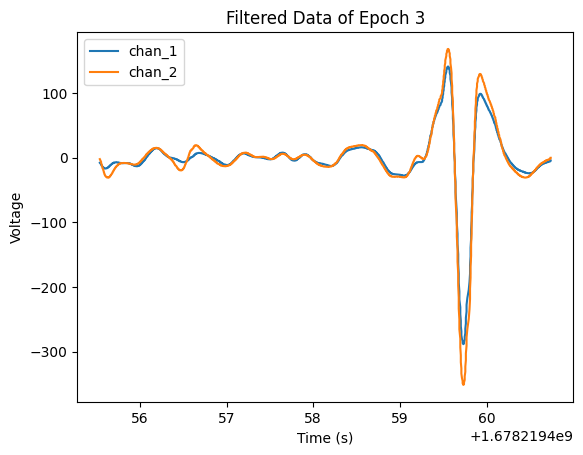

Double blink:


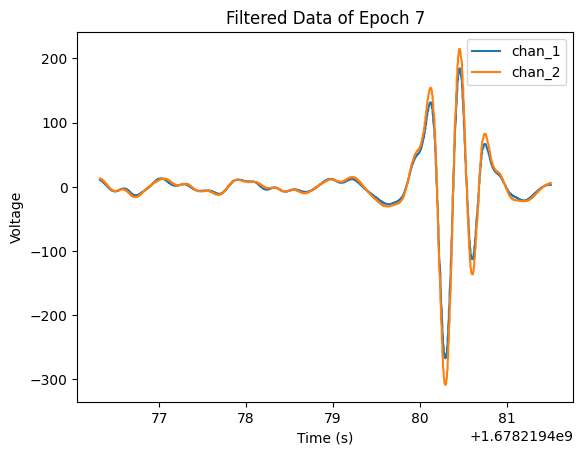

In [7]:
time = df.iloc[:, -2]
filtered_subset, time_subset = divide_dataset(filtered, time)
num_epoch = math.ceil(len(time) / epoch)

print("Single blink:")
for i in range(3,4): # change to (0,num_epoch + 1) to see plots of all epochs
    plt.plot(time_subset[i], filtered_subset[i]['FP1 (channel 1)'], label='chan_1')
    plt.plot(time_subset[i], filtered_subset[i]['FP2 (channel 2)'], label='chan_2')
    plt.title("Filtered Data of Epoch " + str(i))
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage')
    plt.legend()
    plt.show()

print("Double blink:")
for i in range(7,8): # change to (0,num_epoch + 1) to see plots of all epochs
    plt.plot(time_subset[i], filtered_subset[i]['FP1 (channel 1)'], label='chan_1')
    plt.plot(time_subset[i], filtered_subset[i]['FP2 (channel 2)'], label='chan_2')
    plt.title("Filtered Data of Epoch " + str(i))
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage')
    plt.legend()
    plt.show()

In [8]:
avg_min_1, avg_max_1, avg_min_2, avg_max_2 = average_min_max(filtered)
eye_blinks = []

for subset in filtered_subset:
    label = int(svt(subset, avg_min_1, avg_max_1, avg_min_2, avg_max_2))
    eye_blinks.append(label)
    
print("In " + str(len(eye_blinks)), "epochs, " + str(sum(eye_blinks)) + " epochs contain eye blinks:", eye_blinks, ", where 1 indicates an eye blink.")

In 14 epochs, 13 epochs contain eye blinks: [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] , where 1 indicates an eye blink.


c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, 

### Separate single blink and double blink

Single blink:


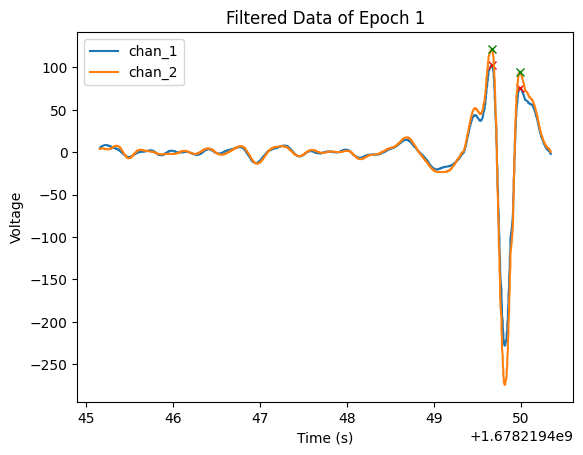

Double blink:


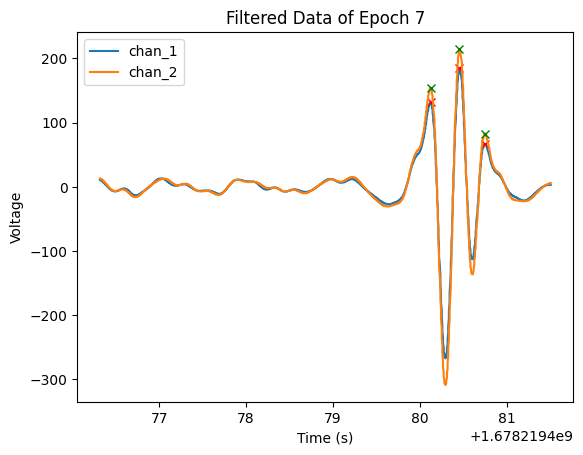

In [9]:
# manually setting the best thresholds to include the whole eyeblink window for both single blink and double blink
# pick 60 
# visualize the graph to see if all peaks are marked according to our threshold
print("Single blink:")
filtered_subset, time_subset = divide_dataset(filtered, time)
for i in range(1,2): # change to (0,num_epoch + 1) to see plots of all epochs
    reset_index = filtered_subset[i]['FP1 (channel 1)'].reset_index(drop=True)
    time_index = time_subset[i].reset_index(drop=True)
    reset_index
    peak, _ = sig.find_peaks(reset_index, height = 65)
    plt.plot(time_subset[i], filtered_subset[i]['FP1 (channel 1)'], label='chan_1')
    plt.plot(time_index[peak], reset_index[peak], "x", color ='red')

    reset_index_2 = filtered_subset[i]['FP2 (channel 2)'].reset_index(drop=True)
    peak_2, _ = sig.find_peaks(reset_index_2, height = 65)
    plt.plot(time_subset[i], filtered_subset[i]['FP2 (channel 2)'], label='chan_2')
    plt.plot(time_index[peak_2], reset_index_2[peak_2], "x", color ='green')
    plt.title("Filtered Data of Epoch " + str(i))
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage')
    plt.legend()
    plt.show()
print("Double blink:")
filtered_subset, time_subset = divide_dataset(filtered, time)
for i in range(7,8): # change to (0,num_epoch + 1) to see plots of all epochs
    reset_index = filtered_subset[i]['FP1 (channel 1)'].reset_index(drop=True)
    time_index = time_subset[i].reset_index(drop=True)
    reset_index
    peak, _ = sig.find_peaks(reset_index, height = 65)
    plt.plot(time_subset[i], filtered_subset[i]['FP1 (channel 1)'], label='chan_1')
    plt.plot(time_index[peak], reset_index[peak], "x", color ='red')

    reset_index_2 = filtered_subset[i]['FP2 (channel 2)'].reset_index(drop=True)
    peak_2, _ = sig.find_peaks(reset_index_2, height = 65)
    plt.plot(time_subset[i], filtered_subset[i]['FP2 (channel 2)'], label='chan_2')
    plt.plot(time_index[peak_2], reset_index_2[peak_2], "x", color ='green')
    plt.title("Filtered Data of Epoch " + str(i))
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage')
    plt.legend()
    plt.show()

In [10]:
# test the values of the points
print(max(filtered_subset[1]['FP1 (channel 1)']), max(filtered_subset[7]['FP1 (channel 1)']))
print(max(filtered_subset[1]['FP2 (channel 2)']), max(filtered_subset[7]['FP2 (channel 2)']))

103.25150893173998 184.55144970900298
121.82093868110569 214.8329890481411


In [11]:
# manually pick out the peaks in eyeblinks
peaks_1, _ = sig.find_peaks(filtered['FP1 (channel 1)'], height = 65)
peaks_2, _ = sig.find_peaks(filtered['FP2 (channel 2)'], height = 65)

In [12]:
def mark_blink(peaks):
    """
    Applies a high pass filter to the voltage data in the dataframe.

    Parameters:
    data: A 1D list containing the indecies of the peak.

    Returns:
    A list containing the start time and end time of a peak
    """
    blink_times = []
    for i in range(len(peaks)):
        start = peaks[i]
        if i + 1 < len(peaks):
            end = peaks[i + 1]
        else:
            end = len(time) -1
        blink_times.append((start, end))
    return blink_times
def extract_features(blink_times, time, eeg_data):
    """
    Extract different features of the peaks.

    Parameters:
    data: A 1D list containing the start time and end time of a peak, the time data, and the 
    corresponding values of data

    Returns:
    A list containing the duration, the peak, and the number of points in the interval
    """
    blink_features = []
    for blink in blink_times:
        duration = time[blink[1]] - time[blink[0]]
        peak = eeg_data[blink[0]]
        frequency = blink[1] - blink[0]
        blink_features.append((duration, peak, frequency))
    return blink_features
def separate_blink(blink_features):
    """
    Separate single blink from double blink.

    Parameters:
    data: blink_features

    Returns:
    A list that stores all single blink, a list that stores all double blink.
    """
    single_blink = []
    double_blink = [] 
    for i in range(len(blink_features)):
        if blink_features[i][0] < 1:
            if i + 1 < len(blink_features) and blink_features[i+1][0] < 1:
                duration = blink_features[i][0] + blink_features[i+1][0]
                peak = max(blink_features[i][1], blink_features[i+1][1])
                frequency = blink_features[i][2] + blink_features[i+1][2]
                double_blink.append((duration, peak, frequency))
            elif i + 1 < len(blink_features) and blink_features[i+1][0] >= 1:
                duration = blink_features[i][0]
                peak = max(blink_features[i][1], blink_features[i+1][1])
                frequency = blink_features[i][2]
                single_blink.append((duration, peak, frequency))
    return single_blink, double_blink

In [13]:
# mark the peaks that represent when an eyeblink occurs
blink_times_fp1 = mark_blink(peaks_1)
blink_times_fp2 = mark_blink(peaks_2)

In [14]:
# extract blink features
blink_features_1 = extract_features(blink_times_fp1, time, filtered['FP1 (channel 1)'])
blink_features_2 = extract_features(blink_times_fp2, time, filtered['FP2 (channel 2)'])

In [15]:
# example of a single blink, where the duration between the two peaks is approximately 0.32s
# and it only contains two peaks
blink_features_1[0:2]

[(0.3210029602050781, 103.25150893173998, 84),
 (4.922468185424805, 75.7862074057192, 1231)]

In [16]:
# example of a single blink, where the duration between the two peaks is approximately 0.67s
# and it only contains three peaks
blink_features_1[17:20]

[(3.86611008644104, 69.19813186351564, 968),
 (0.3305180072784424, 100.89625920733118, 83),
 (0.35239696502685547, 205.96323343591126, 88)]

In [17]:
# separate single blinks and double blinks in both channels
single_blink_fp1, double_blink_fp1 = separate_blink(blink_features_1)
single_blink_fp2, double_blink_fp2 = separate_blink(blink_features_2)

In [18]:
print("number of single eye blinks is:")
print(len(single_blink_fp1), len(single_blink_fp2))
print("number of double eye blinks is")
print(len(double_blink_fp1), len(double_blink_fp2))

number of single eye blinks is:
13 13
number of double eye blinks is
5 5
